# NGC7752

We present the NGC7752 galaxy, a spiral galaxy located in the constellation Pegasus. It is part of the NGC 7753 group of galaxies and is approximately 100 million light-years away from Earth. In this study we explore the HI content of NGC7752 trhough moment maps. 

Author: Angel Salazar

In [3]:
import  numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from reproject import reproject_interp
from astroquery.skyview import SkyView
from astroquery.vizier import Vizier
from spectral_cube import SpectralCube
import glob
from PIL import Image
import os
from IPython import display
import matplotlib.patches as patches

In [4]:
directory="/home/angeldavid/Desktop/Fedora/RESEARCH-INTERSHIPS/data_cubes/NGC7752/"
cube='ngc7752_cube.fits'
mask='S2349+2904_HIcube2_clean_smooth_image_5_mask_kms.fits'

In [5]:
def read_fits_cube(path_file):
    hdul = fits.open(path_file)
    header = hdul[0].header
    data = hdul[0].data
    return header, data

In [6]:
# import data cubes 
header_cube,data_cube=read_fits_cube(directory+cube)
header_mask,data_mask=read_fits_cube(directory+mask)

In [7]:
# apply the mask
data_cube = np.where(data_cube <0,0,data_cube)
masked_data=np.where(data_mask,data_cube,0)

## Integrated Intensity (Moment 0)

In [8]:
mom0_dat = np.nansum(masked_data,axis=0)*abs(header_cube['CDELT3'])/1000

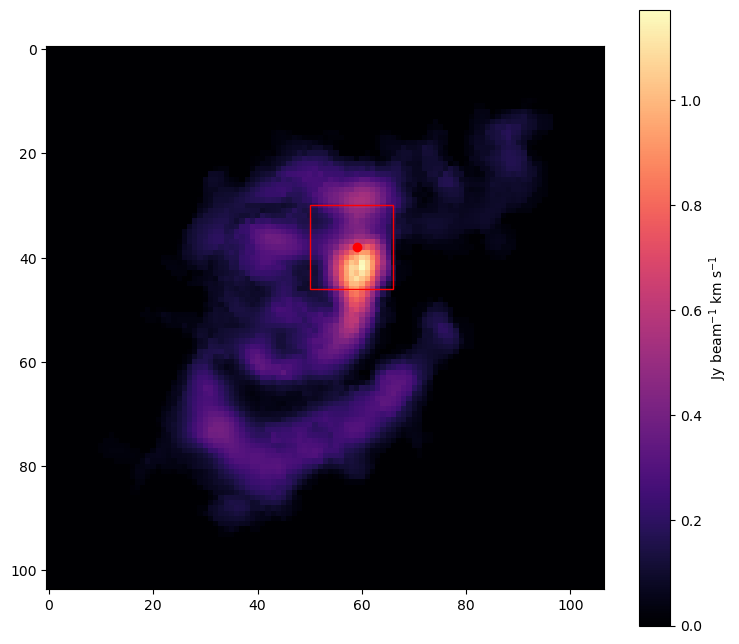

In [9]:
plt.figure(figsize=(9,8))
plt.plot(59,38,marker='o',color='red')
plt.imshow(mom0_dat,cmap='magma')
plt.colorbar(label=r'Jy beam$^{-1}$ km s$^{-1}$')
# add a square: (x,y) is the lower-left corner 
rect = patches.Rectangle((50,30),16,16,linewidth=1,edgecolor='red',facecolor='none')
plt.gca().add_patch(rect)
plt.show()

In [10]:
center_x, center_y = 59, 38
half_width = 8
y, x = np.ogrid[:masked_data.shape[1], :masked_data.shape[2]]
mask = ((np.abs(x - center_x) <= half_width) & (np.abs(y - center_y) <= half_width))

In [11]:
print(masked_data.shape)
print(x.shape)
print(y.shape)

(94, 104, 107)
(1, 107)
(104, 1)


In [12]:
mask3d = mask[None,:,:]
masked_data_crop = np.where(mask3d, masked_data, 0)

In [13]:
computed_mom0_dat = np.nansum(masked_data_crop,axis=0)*abs(header_cube['CDELT3'])/1000

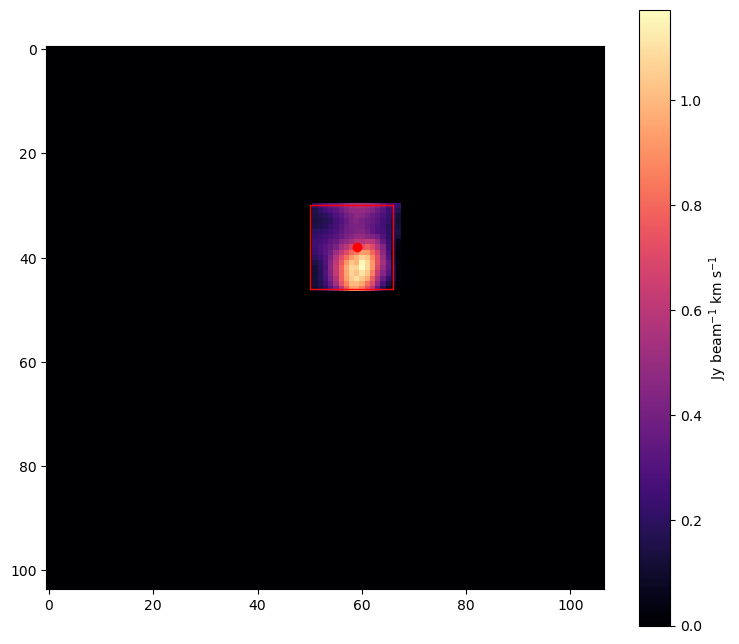

In [14]:
plt.figure(figsize=(9,8))
plt.plot(59,38,marker='o',color='red')
plt.imshow(computed_mom0_dat,cmap='magma')
plt.colorbar(label=r'Jy beam$^{-1}$ km s$^{-1}$')
# add a square: (x,y) is the lower-left corner 
rect = patches.Rectangle((50,30),16,16,linewidth=1,edgecolor='red',facecolor='none')
plt.gca().add_patch(rect)
plt.show()

In [15]:
# saving the data in a afits file
def save_data(h_1,moment,data_mom):
    '''
    -h_1 is the header of the original data cube
    -moment is the name of the  map, this will be used to give the name for the fits file
    -data_mom is the data of the moment map
    '''
    wcs_new = WCS(naxis=2)
    wcs_new.wcs.cdelt = [h_1['CDELT1'], h_1['CDELT2']]
    wcs_new.wcs.ctype = [h_1['CTYPE1'], h_1['CTYPE2']]
    wcs_new.wcs.crval = [h_1['CRVAL1'], h_1['CRVAL2']]
    wcs_new.wcs.crpix = [h_1['CRPIX1'], h_1['CRPIX2']]
    header = wcs_new.to_header()        
    
# add the data and the header to an object that can be written into a file 
    hdul_new = fits.PrimaryHDU(data_mom, header=header) 
    hdul_new.writeto(directory+'{}_.fits'.format(f'ngc7752_{moment}'),overwrite=True)

In [16]:
save_data(header_cube,'mom0',computed_mom0_dat)

In [17]:
mom0_file = "ngc7752_mom0_.fits"
header_mom0,data_mom0 = read_fits_cube(directory+mom0_file)

**Get the optical image for NGC7752, the web where we can find the galaxy image is : https://skyview.gsfc.nasa.gov/current/cgi/query.pl**  
We are going to do and overlay of the moment 0 map with on an optical image of the galaxy, for this we are going to grab an image from an online data base based on the coordinates of the HI data cube. Then we are going to grid the images to eachother to mathc the pixels and make the overlay

In [18]:
optical_file='ngc7752-optical.fits'
header_optical,data_optical=read_fits_cube(directory+optical_file)

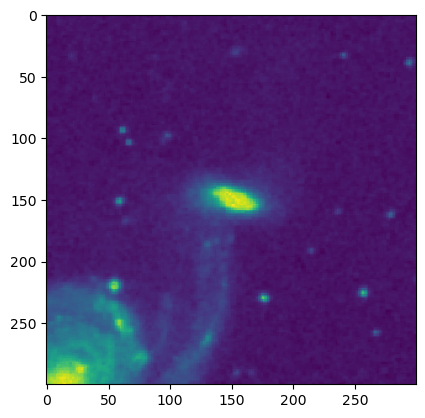

In [19]:
plt.imshow(data_optical)

**Reproject the HI image onto the same pixel grid as the optical image**

In [20]:
def calc_rms(x):
    rms = np.sqrt(np.nanmean(x**2))
    return rms

In [21]:
hdul_mom0=fits.open(directory+mom0_file)
hi_reprojected_0,footprint = reproject_interp(hdul_mom0,header_optical)
rms_mom0 = np.sqrt(np.nanmean(hi_reprojected_0**2))

In [22]:
print(rms_mom0)
print(np.nanmax(hi_reprojected_0))

0.29043203960766223
1.171099305152893


In [23]:
np.nanmax(hi_reprojected_0)/rms_mom0

np.float64(4.0322662290803155)

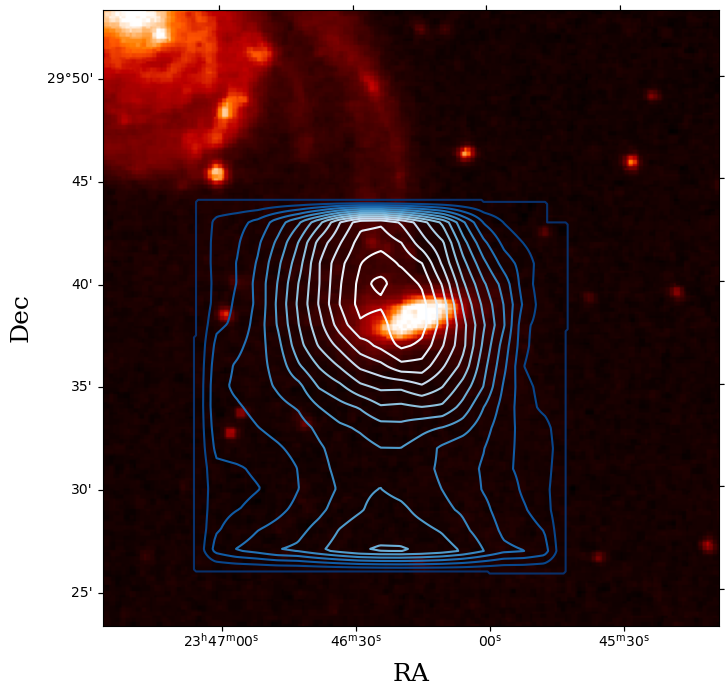

In [24]:
fig=plt.figure(figsize=(9,8))
ax = fig.add_subplot(1,1,1, projection=WCS(header_mom0))
cb=ax.imshow(data_optical,cmap='gist_heat',vmax=np.percentile(data_optical,99.8))
ax.contour(hi_reprojected_0,levels=np.arange(0,3.9,0.3)*rms_mom0,cmap='Blues_r')
#ax.contour(hi_reprojected_0, levels=10,cmap='Blues_r')
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
#cbar=fig.colorbar(cb,ax=ax)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('ngc7752-mom0-optical.png',dpi=300)
plt.show()

## Velocity Field (Moment 1 map)

In [25]:
def compute_moment1(data,header,mom0data):
    d_1_av=np.nansum(data[:,:,:],axis=1)
    d_av=np.nansum(d_1_av[:,:],axis=1)
    spectra=d_av[:-3]
    x_axis=(np.arange(0,len(spectra))*header['CDELT3']+(header['CRVAL3']-header['CRPIX3']*header['CDELT3']))/1000
    d_for_mom1=data.copy()
    for i in range(len(x_axis)):
        d_for_mom1[i,:,:] = x_axis[i]*d_for_mom1[i,:,:]
    d_mom1=np.nansum(d_for_mom1,axis=0)*abs(header['CDELT3'])/(mom0data*1000)
    return d_mom1

In [26]:
# moment1
computed_mom1_dat=compute_moment1(masked_data_crop,header_cube,computed_mom0_dat)

/tmp/ipykernel_6013/2219311961.py:9: RuntimeWarning: invalid value encountered in divide
  d_mom1=np.nansum(d_for_mom1,axis=0)*abs(header['CDELT3'])/(mom0data*1000)


In [27]:
print(np.nanmin(computed_mom1_dat),np.nanmax(computed_mom1_dat))

4757.799 5011.177


Now we are going to do the reprojection with the optical image

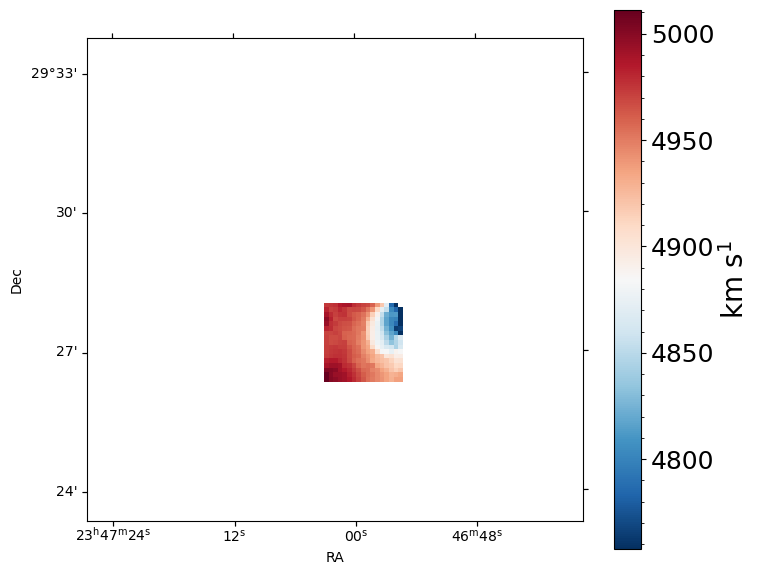

In [28]:
fig = plt.figure(figsize= (8,7))
ax=fig.add_subplot(1,1,1,projection=(WCS(header_mom0)))
cb=plt.imshow(computed_mom1_dat,cmap='RdBu_r')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
cbar=fig.colorbar(cb)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_ylabel(r'km s$^{1}$',fontsize=20)
plt.show()

We are going to save the data for the moment 1 

In [29]:
save_data(header_cube,'mom1',computed_mom1_dat)

In [30]:
# import data for the moment 1 
mom1_file='ngc7752_mom1_.fits'
header_mom1,data_mom1=read_fits_cube(directory+mom1_file)
hdulmom1=fits.open(directory+mom1_file)

In [31]:
# compute the reprojection 
hi_mom1_rep, foot_mom1=reproject_interp(hdulmom1,header_optical)
rms_mom1=(np.sqrt(np.nanmean(hi_mom1_rep**2)))

In [32]:
print(np.nanmin(hi_mom1_rep),np.nanmax(hi_mom1_rep))
print(rms_mom1)

4757.96728515625 5010.68505859375
4931.359852892112


**Overlay of the optical image and the moment 1 map (velocity field)**

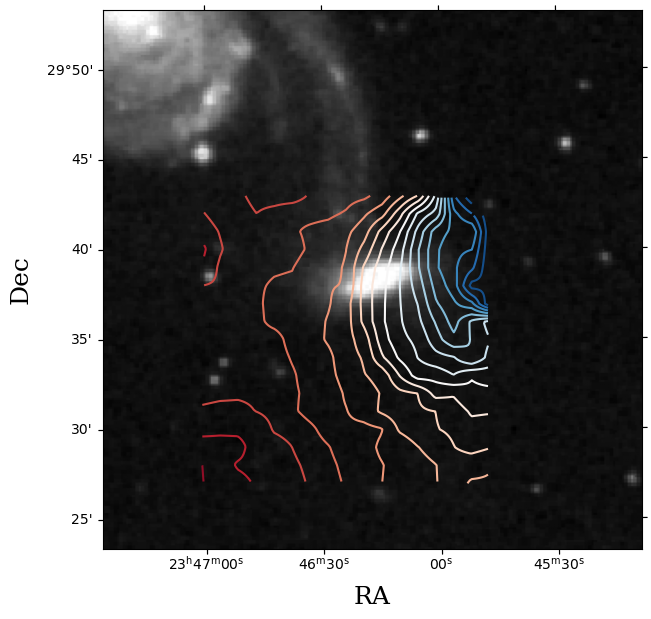

In [33]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(1,1,1, projection=WCS(header_mom1))
ax.imshow(data_optical, cmap='gist_gray',vmax=np.percentile(data_optical, 99.8))
ax.contour(hi_mom1_rep, levels=20,cmap='RdBu_r')
#ax.contour(hi_mom1_rep, levels=np.arange(4800,5300,25),cmap='RdBu_r')
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.title('Overlay of the velocity field with the optical image')
#plt.savefig('mom1.svg')
plt.savefig('ngc7752-mom1-optical.png',dpi=300)
plt.show()

## Velocity Dispersion (Moment 2)

In [34]:
def compute_moment2(data,header,moment1_dat,moment0_dat):
    d_1_av=np.nansum(data[:,:,:],axis=1)
    d_av=np.nansum(d_1_av[:,:],axis=1)
    spectra=d_av[:-3]
    x_axis=(np.arange(0,len(spectra))*header['CDELT3']+(header['CRVAL3']-header['CRPIX3']*header['CDELT3']))/1000
    d_for_mom2=masked_data.copy()
    for i in range(len(x_axis)):
        d_for_mom2[i,:,:]=(x_axis[i]-moment1_dat)**2 * d_for_mom2[i,:,:]
    d_mom2 = np.sqrt(np.nansum(d_for_mom2, axis=0)*(abs(header['CDELT3'])/(moment0_dat*1000)))
    return d_mom2

In [35]:
computed_mom2_dat=compute_moment2(masked_data_crop,header_cube,computed_mom1_dat,computed_mom0_dat)

/tmp/ipykernel_6013/3002096206.py:9: RuntimeWarning: divide by zero encountered in divide
  d_mom2 = np.sqrt(np.nansum(d_for_mom2, axis=0)*(abs(header['CDELT3'])/(moment0_dat*1000)))
/tmp/ipykernel_6013/3002096206.py:9: RuntimeWarning: invalid value encountered in multiply
  d_mom2 = np.sqrt(np.nansum(d_for_mom2, axis=0)*(abs(header['CDELT3'])/(moment0_dat*1000)))


Save data for moment 2

In [36]:
save_data(header_cube,'mom2',computed_mom2_dat)

In [37]:
mom2_file='ngc7752_mom2_.fits'
header_mom2,data_mom2=read_fits_cube(directory+mom2_file)
hdulmom2=fits.open(directory+mom2_file)

In [38]:
hi_mom2_rep, foot_mom2=reproject_interp(hdulmom2,header_optical)
rms_mom2=(np.sqrt(np.nanmean(hi_mom1_rep**2)))

In [39]:
print(rms_mom2)
print(np.nanmin(hi_mom2_rep),np.nanmax(hi_mom2_rep))

4931.359852892112
0.23248343169689178 107.4483413696289


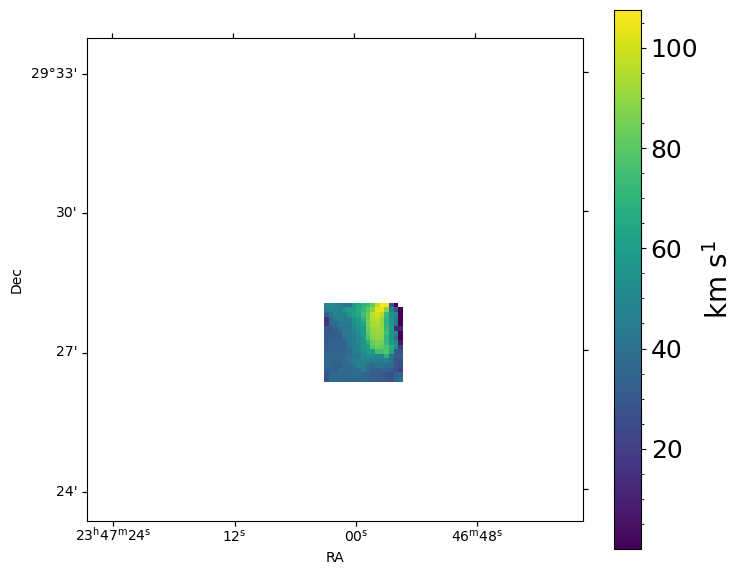

In [40]:
fig = plt.figure(figsize= (8,7))
ax=fig.add_subplot(1,1,1,projection=(WCS(header_mom0)))
cb=plt.imshow(computed_mom2_dat,cmap='viridis')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
cbar=fig.colorbar(cb)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_ylabel(r'km s$^{1}$',fontsize=20)
plt.show()

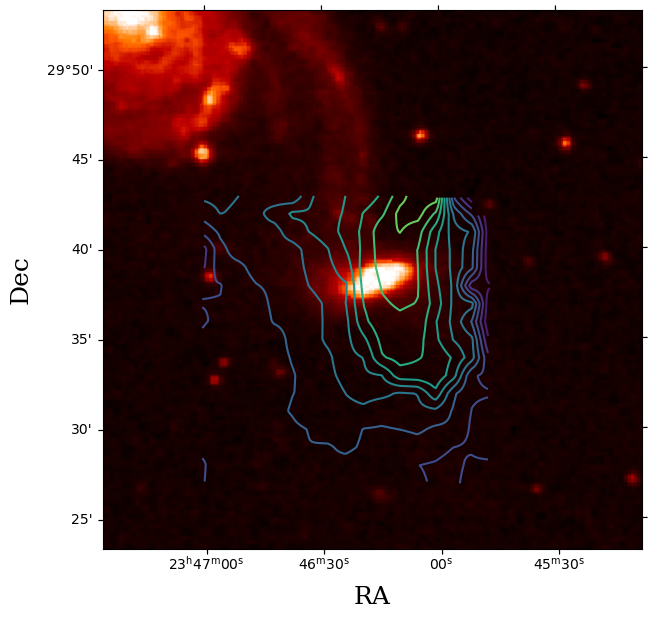

In [41]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(1,1,1, projection=WCS(header_mom2))
ax.imshow(data_optical, cmap='gist_heat',vmax=np.percentile(data_optical, 99.8))
#ax.contour(hi_mom1_rep, levels=10,cmap='RdBu_r')
ax.contour(hi_mom2_rep, levels=np.arange(0,137,10),cmap='viridis')
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.title('Overlay of the velocity field with the optical image')
#plt.savefig('mom1.svg')
plt.savefig('ngc7752-mom2-optical.png',dpi=300)
plt.show()

## BBarolo Model and Comparison

In [42]:
file_model = "/output5/SoFiA_J234703.61+292835.6/SoFiA_J234703.61+292835.6mod_azim.fits"

In [43]:
header_model, data_model = read_fits_cube(directory + file_model)

***Moment 0 map with BBarolo Model***

In [44]:
mom0_dat_model = np.nansum(data_model,axis=0)*abs(header_model['CDELT3'])/1000

***Moment 1 map with BBarolo Model***

In [45]:
mom1_dat_model = compute_moment1(data_model, header_model, mom0_dat_model)

/tmp/ipykernel_6013/2219311961.py:9: RuntimeWarning: invalid value encountered in divide
  d_mom1=np.nansum(d_for_mom1,axis=0)*abs(header['CDELT3'])/(mom0data*1000)


***Moment 2 map with BBarolo Model***

In [46]:
mom2_dat_model = compute_moment2(data_model, header_model, mom1_dat_model,mom0_dat_model)

/tmp/ipykernel_6013/3002096206.py:9: RuntimeWarning: divide by zero encountered in divide
  d_mom2 = np.sqrt(np.nansum(d_for_mom2, axis=0)*(abs(header['CDELT3'])/(moment0_dat*1000)))
/tmp/ipykernel_6013/3002096206.py:9: RuntimeWarning: invalid value encountered in multiply
  d_mom2 = np.sqrt(np.nansum(d_for_mom2, axis=0)*(abs(header['CDELT3'])/(moment0_dat*1000)))


Calculate the residuals of the model

In [47]:
residual_mom0 = computed_mom0_dat -mom0_dat_model
residual_mom1 = computed_mom1_dat - mom1_dat_model
residual_mom2 = computed_mom2_dat - mom2_dat_model

**Maps of the data, model, and residual of each moment**

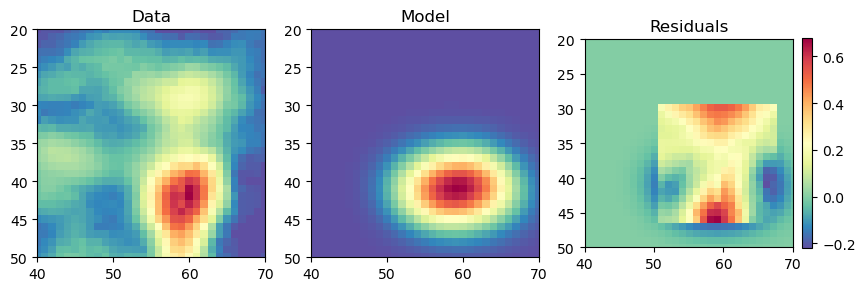

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(10, 17))
im1 = axs[0].imshow(mom0_dat, cmap='Spectral_r')
axs[0].set_title('Data')
axs[0].set_xlim(40, 70)
axs[0].set_ylim(20, 50) 
im2 = axs[1].imshow(mom0_dat_model, cmap='Spectral_r')
axs[1].set_title('Model')
axs[1].set_xlim(40, 70)
axs[1].set_ylim(20, 50)
im3 = axs[2].imshow(residual_mom0, cmap='Spectral_r')
axs[2].set_title('Residuals')
axs[2].set_xlim(40, 70)
axs[2].set_ylim(20, 50)
cbar = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
for ax in axs:
    ax.invert_yaxis()

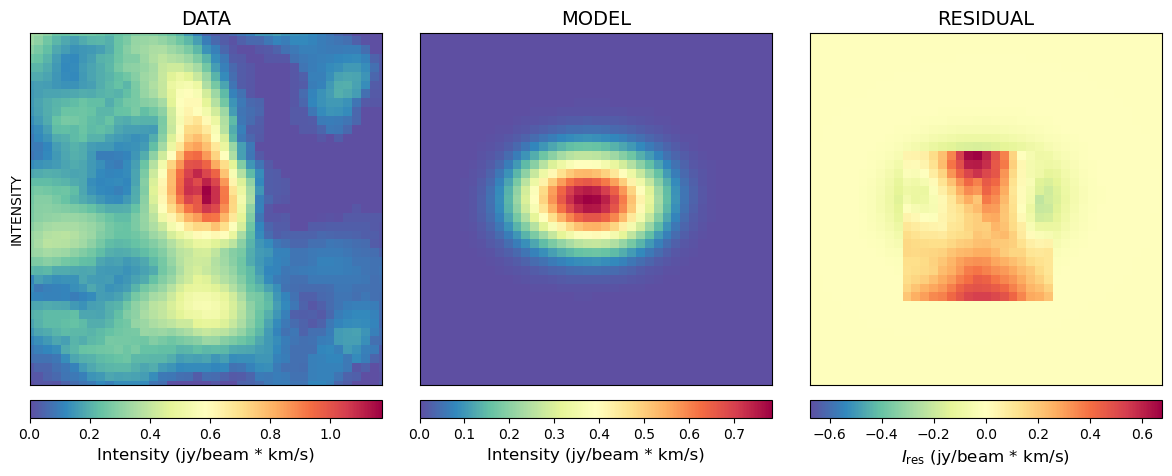

In [65]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'wspace': 0.02})  # tighter spacing

# Common image kwargs
common_kwargs = dict(origin='lower', interpolation='none')

# ---------- Panel 1: DATA ----------
im1 = axs[0].imshow(mom0_dat, cmap='Spectral_r', **common_kwargs)
axs[0].set_title('DATA', fontsize=14)
axs[0].set_ylabel('INTENSITY')
axs[0].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
axs[0].set_xlim(40, 80)
axs[0].set_ylim(20, 60) 

# Add shared colorbar below first two panels
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("bottom", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('Intensity (jy/beam * km/s)', fontsize=12)

# ---------- Panel 2: MODEL ----------
im2 = axs[1].imshow(mom0_dat_model, cmap='Spectral_r', **common_kwargs)
axs[1].set_title('MODEL', fontsize=14)
axs[1].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
axs[1].set_xlim(40, 80)
axs[1].set_ylim(20, 60)

# Share colorbar with first panel
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="5%", pad=0.15)
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('Intensity (jy/beam * km/s)', fontsize=12)

# ---------- Panel 3: RESIDUAL ----------
resid_abs_max = np.nanmax(np.abs(residual_mom0))
im3 = axs[2].imshow(residual_mom0, cmap='Spectral_r', vmin=-resid_abs_max, vmax=resid_abs_max, **common_kwargs)
axs[2].set_title('RESIDUAL', fontsize=14)
axs[2].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
axs[2].set_xlim(40, 80)
axs[2].set_ylim(20, 60)

# Separate colorbar for residuals
divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes("bottom", size="5%", pad=0.15)
cbar3 = plt.colorbar(im3, cax=cax3, orientation='horizontal')   
cbar3.set_label(r'$I_{\mathrm{res}}$ (jy/beam * km/s)', fontsize=12)

# Equal aspect ratio for all panels
for ax in axs:
    ax.set_aspect('equal')

# Optional export
plt.savefig("ngc7752-moment0-residuals.png", dpi=300, bbox_inches='tight')
# plt.savefig("moment0_model.eps",format="eps", dpi=300, bbox_inches='tight')
plt.show()


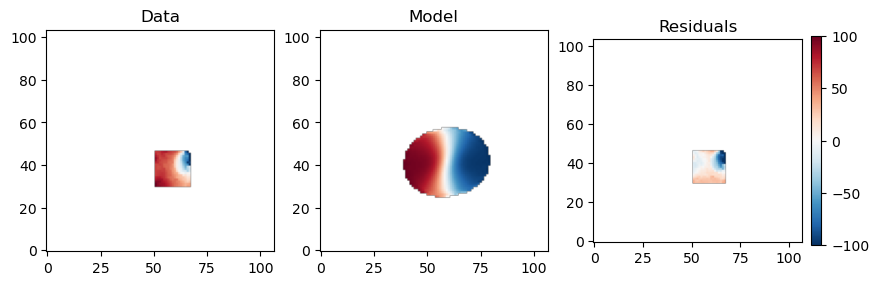

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(10, 17))
im1 = axs[0].imshow(computed_mom1_dat, cmap='RdBu_r')
axs[0].set_title('Data')
im2 = axs[1].imshow(mom1_dat_model, cmap='RdBu_r')
axs[1].set_title('Model')
im3 = axs[2].imshow(residual_mom1, cmap='RdBu_r', vmax=100, vmin=-100)
axs[2].set_title('Residuals')
cbar = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
for ax in axs:
    ax.invert_yaxis()

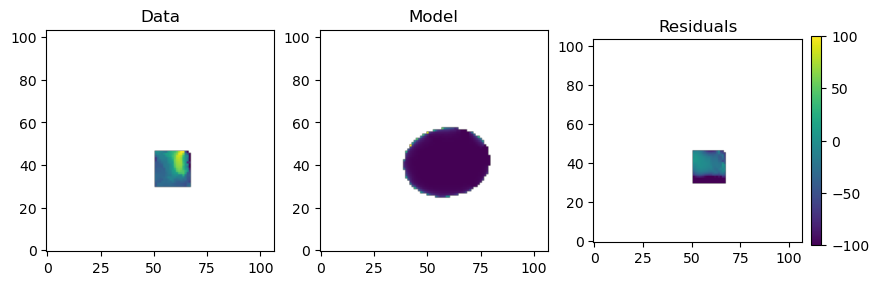

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(10, 15))
im1 = axs[0].imshow(computed_mom2_dat, cmap='viridis')
axs[0].set_title('Data')
im2 = axs[1].imshow(mom2_dat_model, cmap='viridis')
axs[1].set_title('Model')
im3 = axs[2].imshow(residual_mom2, cmap='viridis',vmin=-100,vmax=100)
axs[2].set_title('Residuals')
cbar = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
for ax in axs:
    ax.invert_yaxis()

## Prepare the data for the third galaxy 

In [51]:
data_galaxy3=data_cube -data_model

In [52]:
mom0_dat_new = np.nansum(data_galaxy3,axis=0)*abs(header_model['CDELT3'])/1000

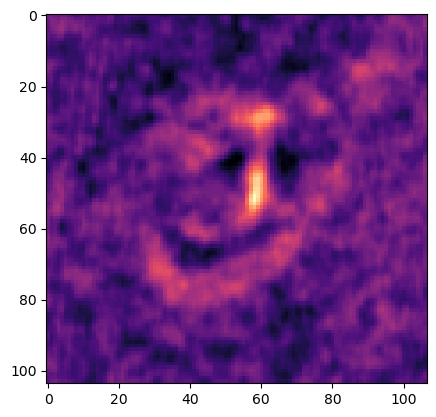

In [53]:
# quick inspection
plt.imshow(mom0_dat_new,cmap='magma')

In [54]:
directory_new = "/home/angeldavid/Desktop/Fedora/RESEARCH-INTERSHIPS/data_cubes/USNOA2-1125-19940303/"
hdul_new = fits.PrimaryHDU(data_galaxy3,header=header_cube)
hdul_new.writeto(directory_new + 'arp86-3_cube.fits', overwrite=True)